In [51]:

from experiment_information import *
from data import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as np
import numpy as np
import logging
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments_cluster.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

def explode_calibrations(df):
    a = df["calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["calibrations"])
    # concat the original dataframe with the new dataframe containing the exploded calibrations column
    df = pd.concat([df,a],axis=1)
    # explode both calibrations and ps columns
    df = df.explode(["calibrations","ps"])
    # rename the exploded columns
    df = df.rename(columns={"calibrations":"calibration","ps":"p"})
    return df
df_state_evolution = explode_calibrations(df_state_evolution)
def explode_erm_calibrations(df):
    a = df["erm_calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["erm_calibrations"])
    b = df["analytical_calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["analytical_calibrations"])
    # drop the dp and ps columns from b
    b = b.drop(columns=["dp","ps"])
    # rename the columns of b
    b = b.rename(columns={"calibrations":"analytical_calibration"})
    # rename the columns of a
    a = a.rename(columns={"calibrations":"erm_calibration"})
    # concat the original dataframe with the new dataframe containing the exploded calibrations column
    df = pd.concat([df,a],axis=1)
    df = pd.concat([df,b],axis=1)
    # explode both calibrations and ps columns
    df = df.explode(["erm_calibration","analytical_calibration","ps"])
    # rename the exploded columns
    df = df.rename(columns={"ps":"p"})
    return df
df_erm = explode_erm_calibrations(df_erm)
print("Current code version, ", __version__)

Current code version,  44


In [53]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
version_choice = "42"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(20)

experiment_id     experiment_name      duration  \
17  f78f72db-a2e0-4c18-9774-f6689561501a  Default Experiment  17326.323057   
16  d2f0738a-7303-4ca7-9a4e-1e4a149b2e97  Default Experiment  13215.756993   
15  e027ebce-e617-41b4-a784-5230563b5250  Default Experiment   3620.246897   

   code_version                 date  state_evolution_repetitions  \
17           42  2023-05-03 23:50:46                            1   
16           42  2023-05-03 23:42:47                            1   
15           42  2023-05-03 23:29:08                            1   

    erm_repetitions                                             alphas  \
17               10                                         [2, 5, 15]   
16               10  [10.0, 11.787686347935873, 13.894954943731374,...   
15               10  [0.1, 0.35789473684210527, 0.6157894736842106,...   

                       epsilons  \
17  [0.0, 0.25, 0.5, 0.75, 1.0]   
16  [0.0, 0.25, 0.5, 0.75, 1.0]   
15  [0.0, 0.25, 0.5, 0.75, 1.0]   

                                              lambdas        taus      ps  \
17  [0.001, 0.0018329807108324356, 0.0033598182862...  [0.1, 1.0]  [0.75]   
16                                        [0.01, 1.0]  [0.1, 1.0]  [0.75]   
15                                        [0.01, 1.0]  [0.1, 1.0]  [0.75]   

      dp     d  erm_methods  completed  
17  0.01  1000  ["sklearn"]          1  
16  0.01  1000  ["sklearn"]          1  
15  0.01  1000  ["sklearn"]          1

In [54]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [55]:
# extract and print the top experiment_id
experiment_id = df_experiments.iloc[0]["experiment_id"]
print(experiment_id)
# experiment_id = "031d5eb9-bf79-4ffb-9fb3-eabedcd350b0"

# This guy was interesting in version 25 for the q- state evolution adaptation
# a2a3016c-8264-4599-ac8f-b457da2790ba
# this guy is interesting in version 28! q-state evolution - best erm so far, close call
# b5f9faf7-ec66-490c-ac99-841888f3fedf
# experiment_id = "b5f9faf7-ec66-490c-ac99-841888f3fedf"
# version 30: 7b921b61-0b48-48a8-8ead-78bc5804597f - q state evolution. Overlaps match except for lambda = 1 in the settings tau=0,2, lam=5*1e-5 for epsilon up to 0.7
# version 30: f92b13d1-c020-46c0-a3cd-5e0578b831a5 - Q state evolution. Same setting as above but not matching overlap.

# version 36 on cluster: 58b544ab-3536-4eb7-bbb9-743f471f6bb3

f78f72db-a2e0-4c18-9774-f6689561501a


In [56]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
# ceil the alpha values to 1 decimal
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: round(x,1))
erm = df_erm[df_erm["experiment_id" ] == experiment_id]
# gd = erm[erm["chosen_minimizer"] == "gd"]
# gd = erm[erm["chosen_minimizer"] == "L-BFGS-B"]
# gd = erm[erm["chosen_minimizer"] == "logistic"]
gd = erm[erm["chosen_minimizer"] == "sklearn"]
# ceil the alpha values to 1 decimal
gd["alpha"] = gd["alpha"].apply(lambda x: round(x,1))
# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam","p"])
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","p"])
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","m","cosb","training_loss","calibration","estimation_error","sigma_hat","q_hat","m_hat"]]
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb", "training_error","d", "training_loss","erm_calibration","analytical_calibration","test_loss"]]
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm','m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm',"training_loss_state_evolution","training_loss_erm","training_error_erm","d_erm","erm_calibration_erm","analytical_calibration_erm","calibration_state_evolution","test_loss_erm","estimation_error_state_evolution","sigma_hat_state_evolution","q_hat_state_evolution","m_hat_state_evolution"]]
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3,4]).agg([np.mean,np.std])
# display all columns
# pd.set_option('display.max_columns', None)
# # display all rows
# pd.set_option('display.max_rows', None)
df

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_66004/964463932.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: round(x,1))


generalization_error_state_evolution       \
                                                                  mean  std   
alpha epsilon tau lam        p                                                
2.0   0.0     0.1 0.001000   0.75                             0.183632  0.0   
                  0.001833   0.75                             0.182739  0.0   
                  0.003360   0.75                             0.181795  0.0   
                  0.006158   0.75                             0.180871  0.0   
                  0.011288   0.75                             0.180117  0.0   
...                                                                ...  ...   
15.0  1.0     1.0 8.858668   0.75                             0.274129  0.0   
                  16.237767  0.75                             0.275253  0.0   
                  29.763514  0.75                             0.276163  0.0   
                  54.555948  0.75                             0.276791  0.0   
                  100.000000 0.75                             0.277185  0.0   

                                  generalization_error_erm_erm            \
                                                          mean       std   
alpha epsilon tau lam        p                                             
2.0   0.0     0.1 0.001000   0.75                     0.183419  0.005795   
                  0.001833   0.75                     0.182900  0.006071   
                  0.003360   0.75                     0.179797  0.004800   
                  0.006158   0.75                     0.181896  0.005273   
                  0.011288   0.75                     0.180678  0.005749   
...                                                        ...       ...   
15.0  1.0     1.0 8.858668   0.75                     0.345691  0.051431   
                  16.237767  0.75                     0.323053  0.004526   
                  29.763514  0.75                     0.387291  0.069404   
                  54.555948  0.75                     0.285160  0.002504   
                  100.000000 0.75                     0.284880  0.003674   

                                  generalization_error_overlap_erm            \
                                                              mean       std   
alpha epsilon tau lam        p                                                 
2.0   0.0     0.1 0.001000   0.75                         0.183581  0.005443   
                  0.001833   0.75                         0.183186  0.006076   
                  0.003360   0.75                         0.180038  0.004070   
                  0.006158   0.75                         0.182176  0.005254   
                  0.011288   0.75                         0.180811  0.005275   
...                                                            ...       ...   
15.0  1.0     1.0 8.858668   0.75                         0.344997  0.051061   
                  16.237767  0.75                         0.323147  0.004362   
                  29.763514  0.75                         0.387153  0.069315   
                  54.555948  0.75                         0.285119  0.002810   
                  100.000000 0.75                         0.284889  0.002689   

                                  sigma_state_evolution       \
                                                   mean  std   
alpha epsilon tau lam        p                                 
2.0   0.0     0.1 0.001000   0.75            210.758915  0.0   
                  0.001833   0.75            118.242251  0.0   
                  0.003360   0.75             66.965324  0.0   
                  0.006158   0.75             38.431279  0.0   
                  0.011288   0.75             22.457831  0.0   
...                                                 ...  ...   
15.0  1.0     1.0 8.858668   0.75              0.080667  0.0   
                  16.237767  0.75              0.050277  0.0   
                  29.763514  0.75    

In [57]:
first_iteration = "tau"
second_iteration = "alpha"
target = "lam"
sweep = "epsilon"
def create_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True):
    df2 = df.reset_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    for tau in df2[first_iteration].unique():
        for lam in df2[second_iteration].unique():
            # Filter the dataframe for the current values of tau and lam
            data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam)]
            
            for i, epsilon in enumerate(data[sweep].unique()):
                # Filter the dataframe for the current value of epsilon
                epsilon_subset = data[data[sweep] == epsilon]

                # Plot the state_evolution results as a line
                if state_evolution_name is not None:
                    plt.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon}', color=palette[i])
                
                # Plot the gradient_descent results as points with error bars
                if gd_name is not None:
                    try:
                        plt.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                    except:
                        pass
            
            if log_x:
                plt.xscale('log')
            if log_y:
                plt.yscale('log')

            # Add labels and title
            plt.xlabel(target)
            plt.ylabel(error_name)
            plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d}')
            # Add a legend
            plt.legend()

            # add a grid
            plt.grid()

            name = f"{error_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
            # Save the plot as svg
            plt.savefig(f"Assets/{name}.svg")

            # Show the plot
            plt.show()

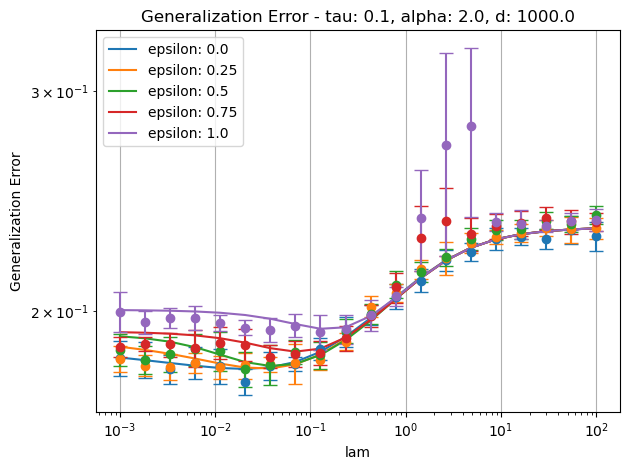

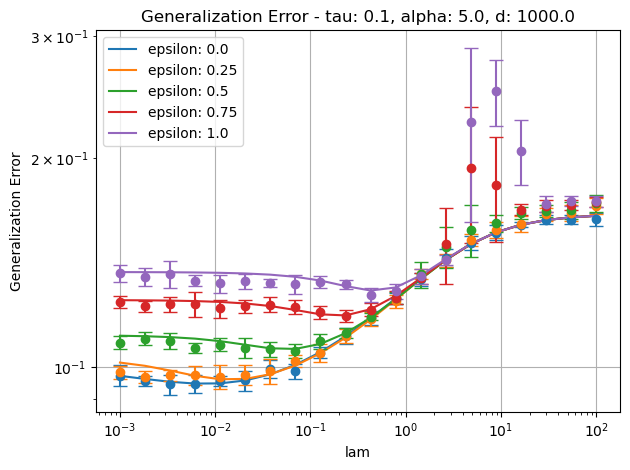

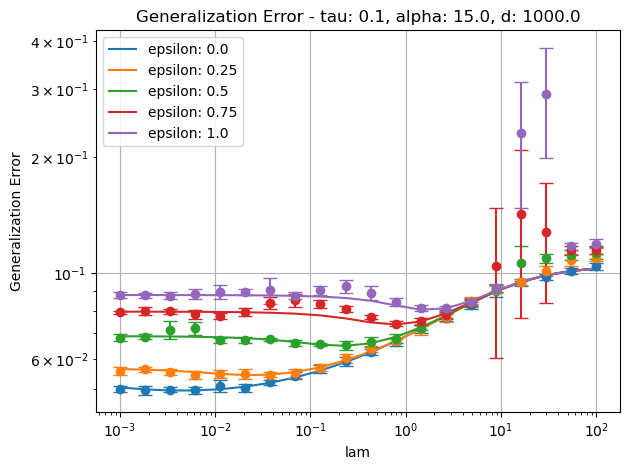

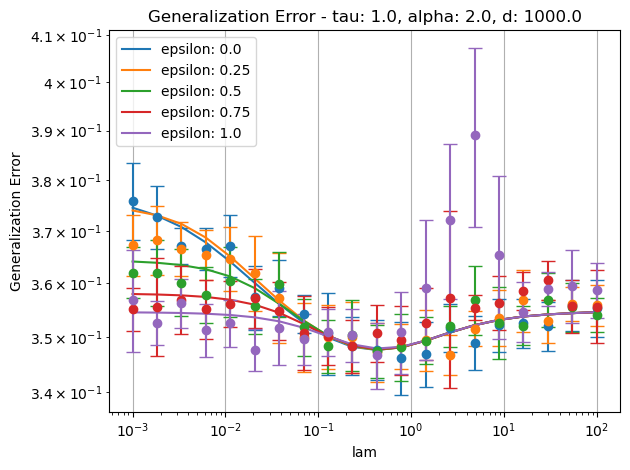

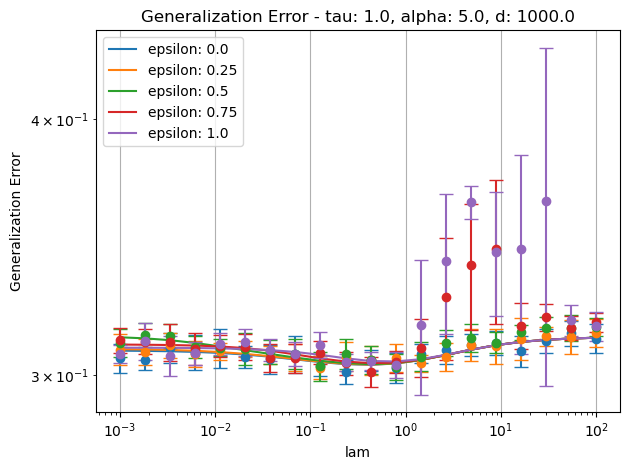

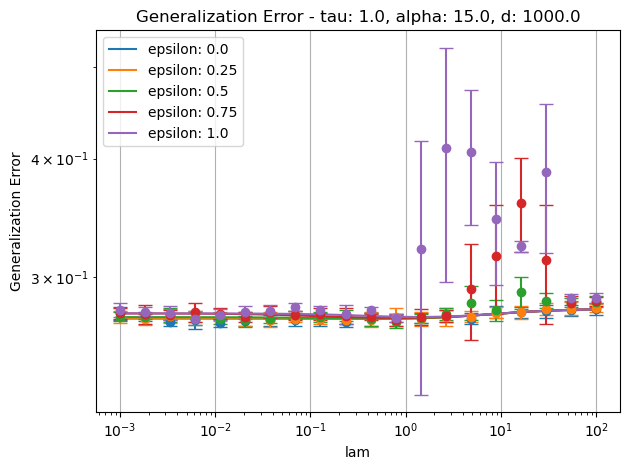

In [58]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm")

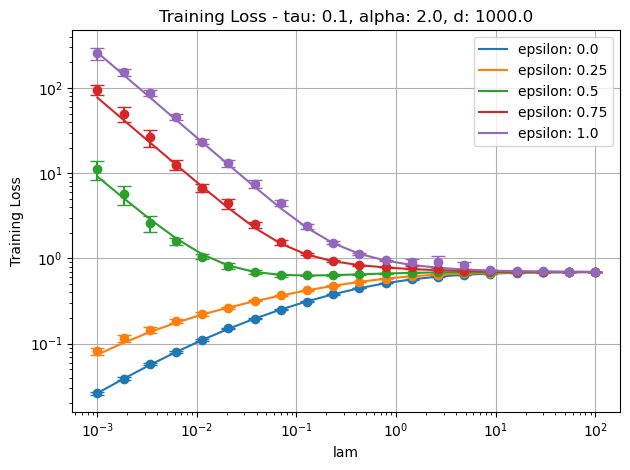

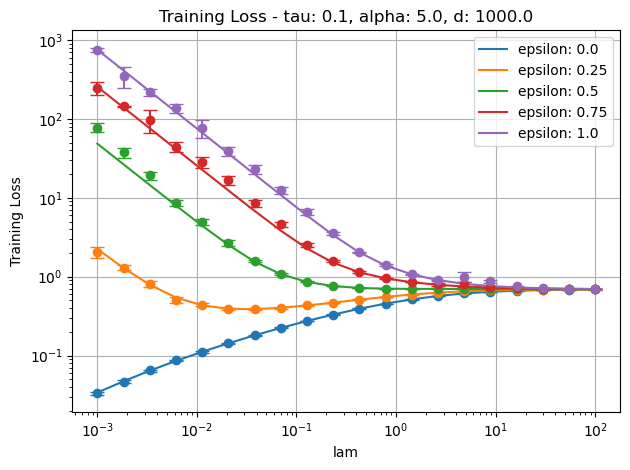

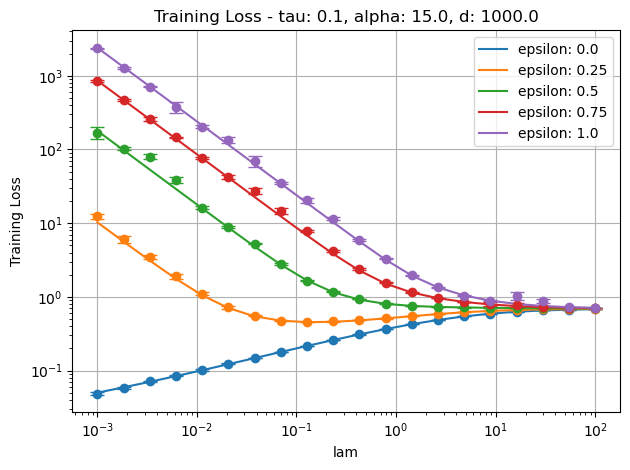

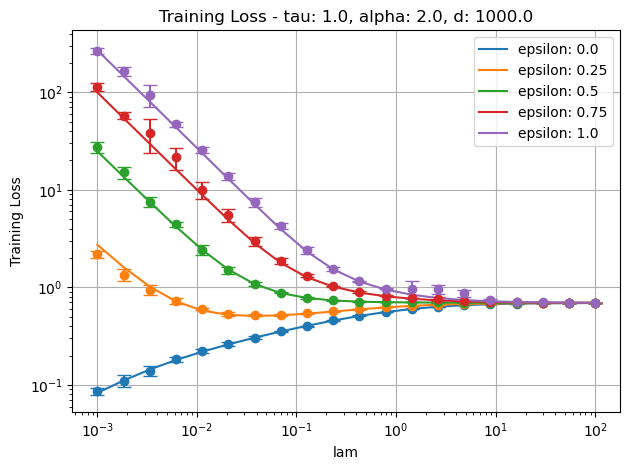

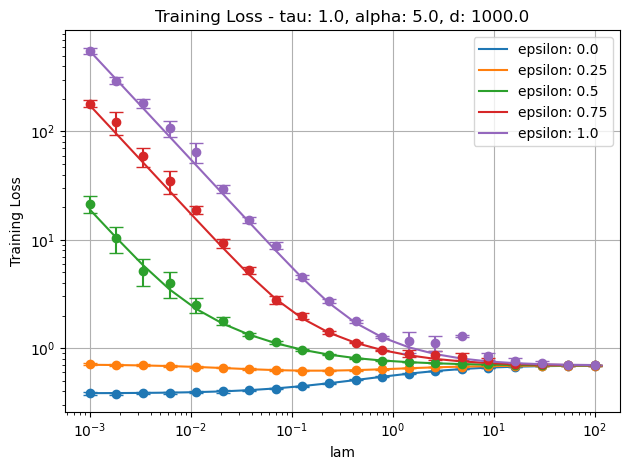

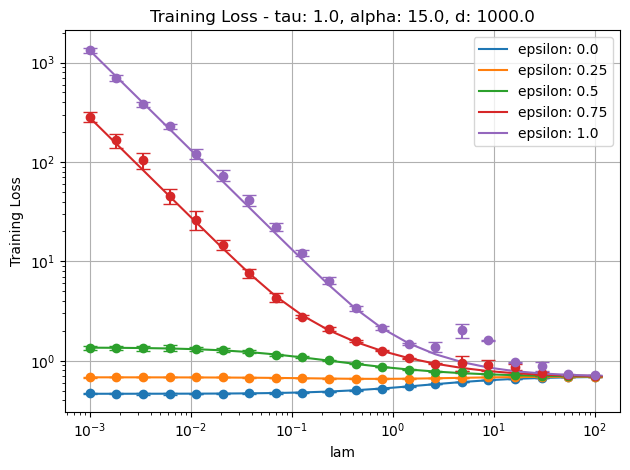

In [59]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=True)

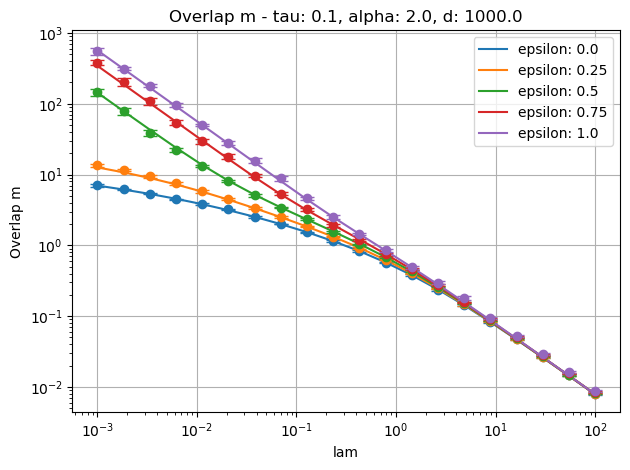

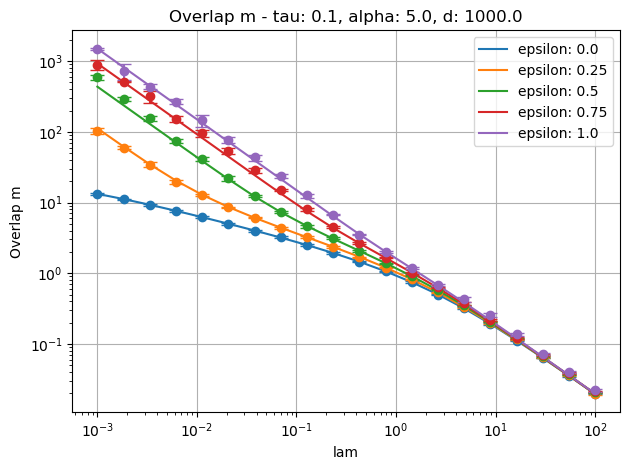

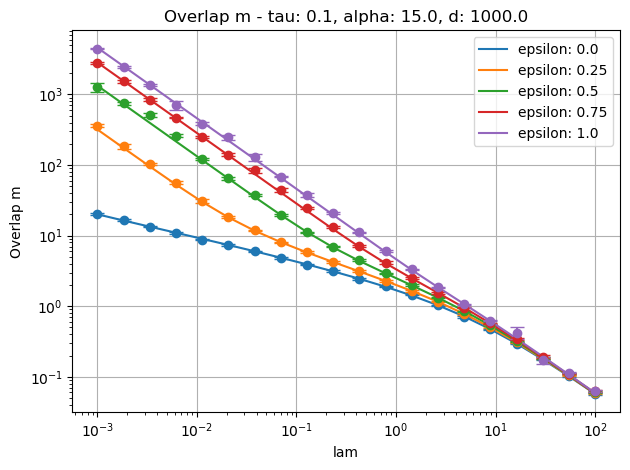

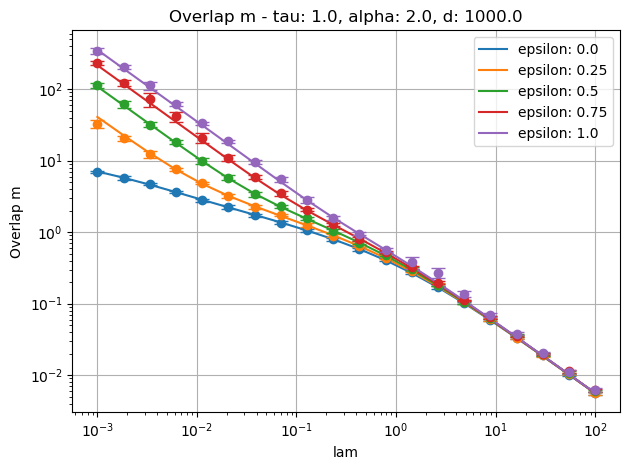

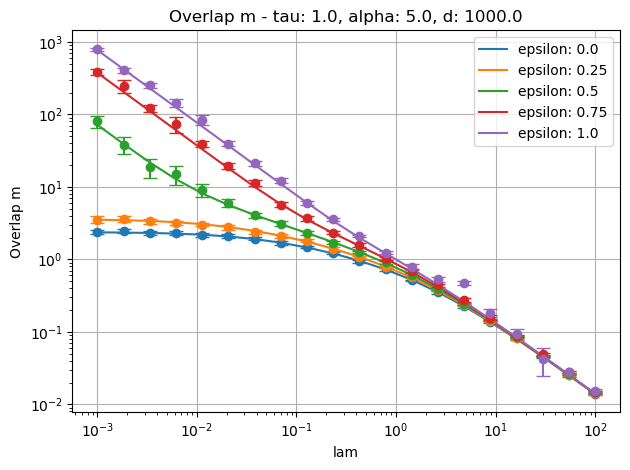

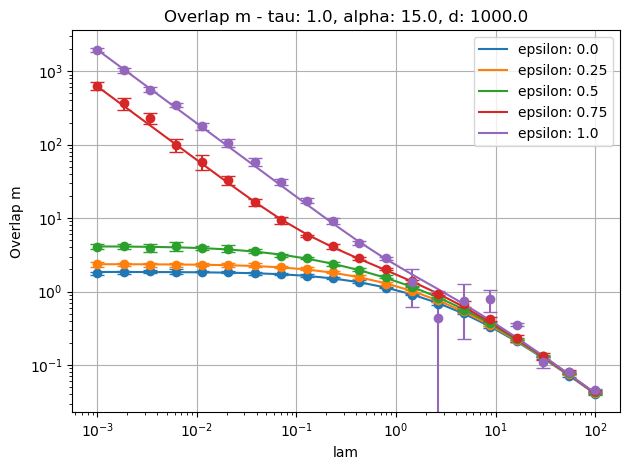

In [60]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_y=True)

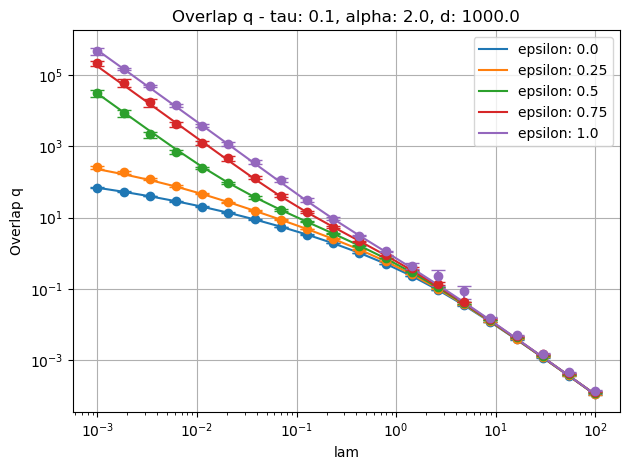

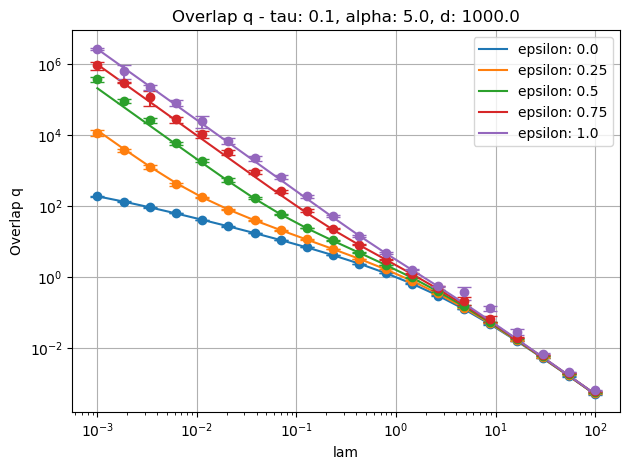

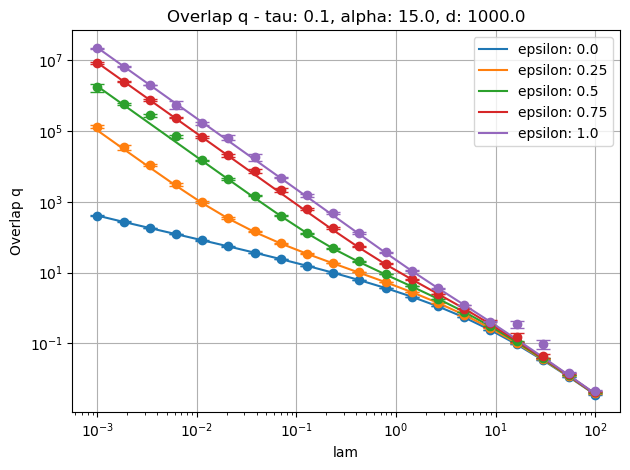

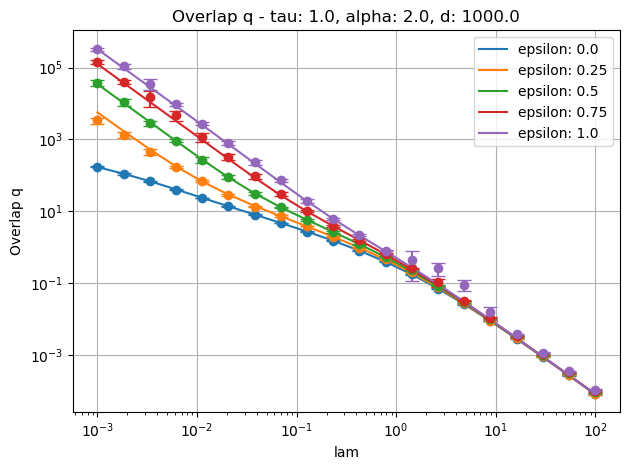

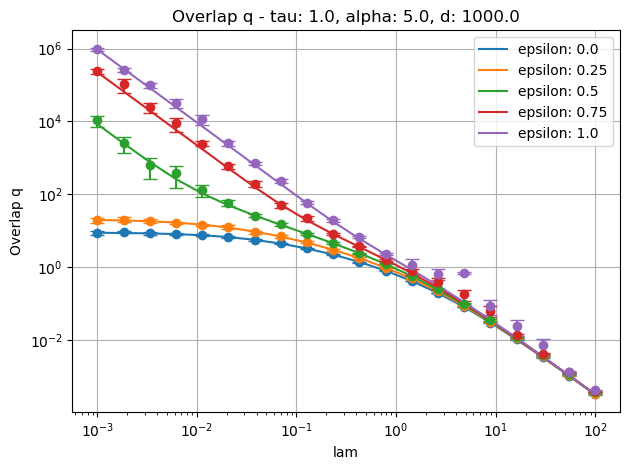

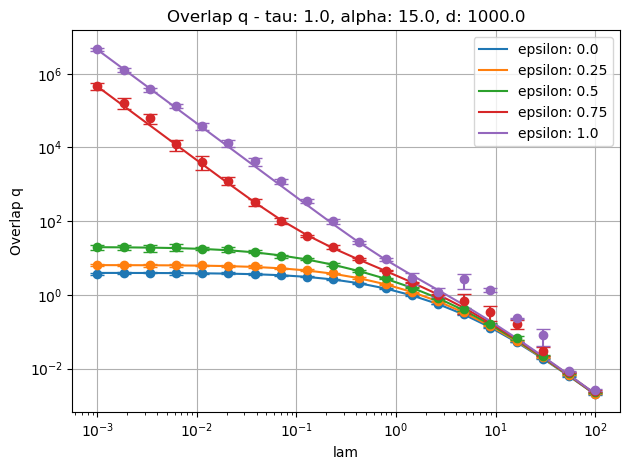

In [61]:
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_y=True)

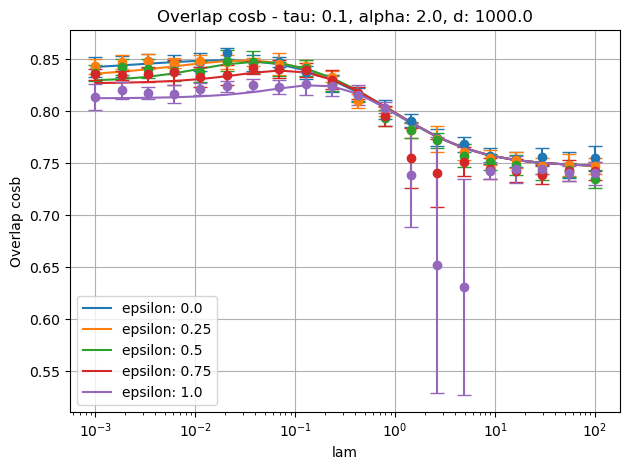

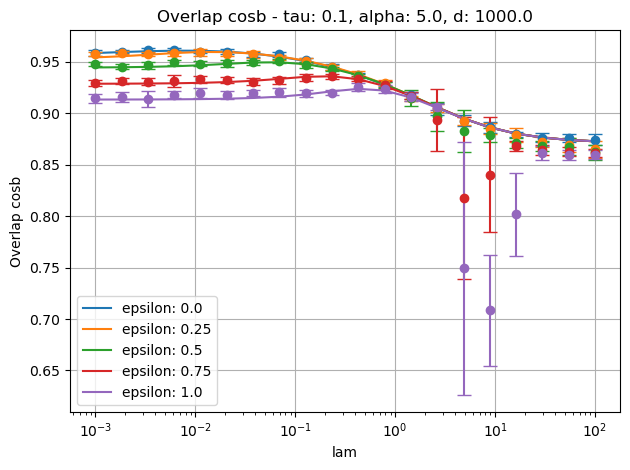

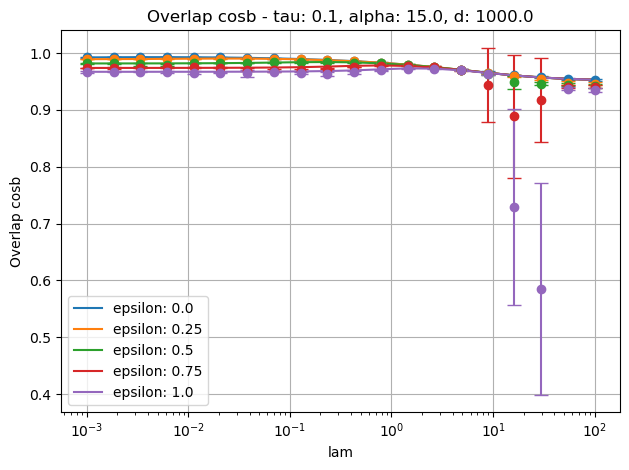

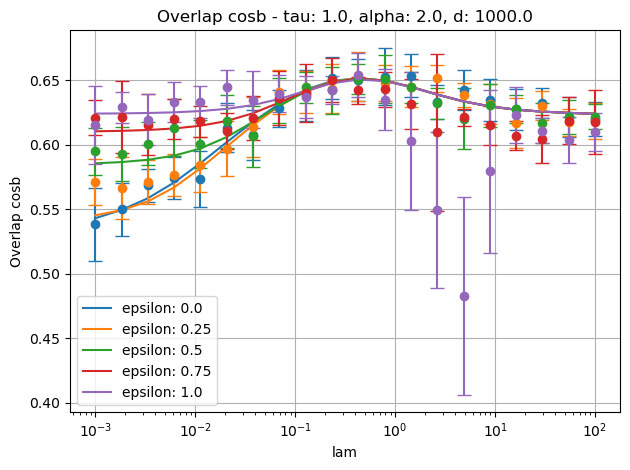

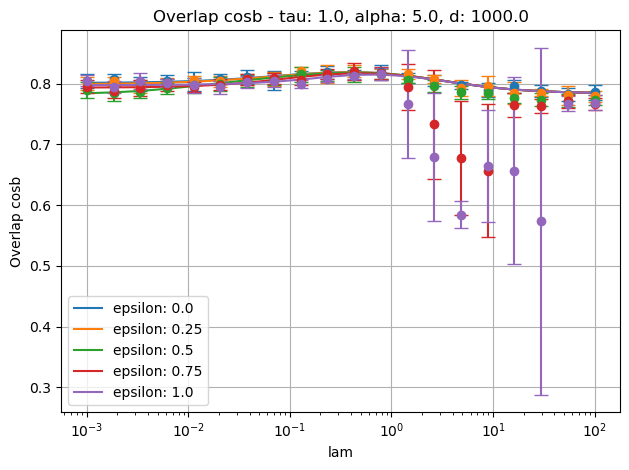

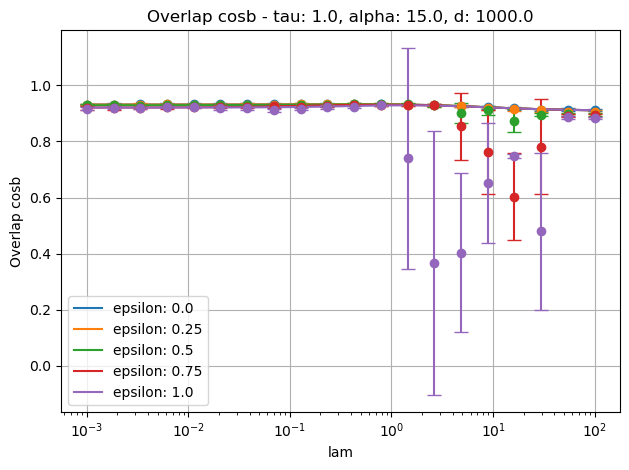

In [62]:
create_plot(df, "Overlap cosb", "cosb_state_evolution","cosb_erm",log_y=False)

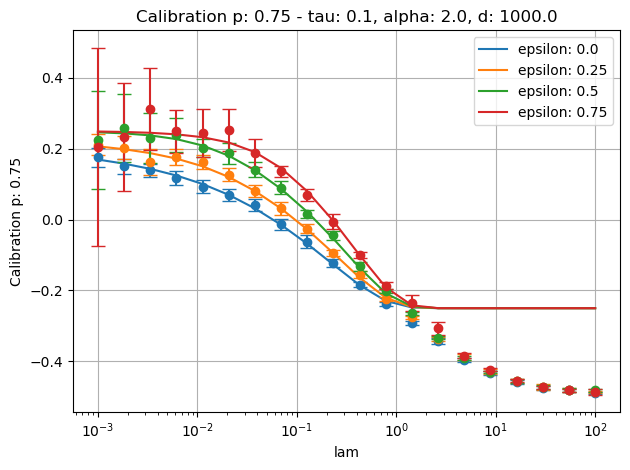

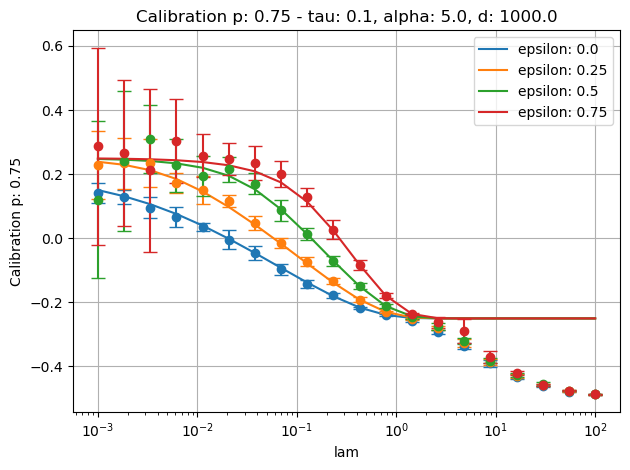

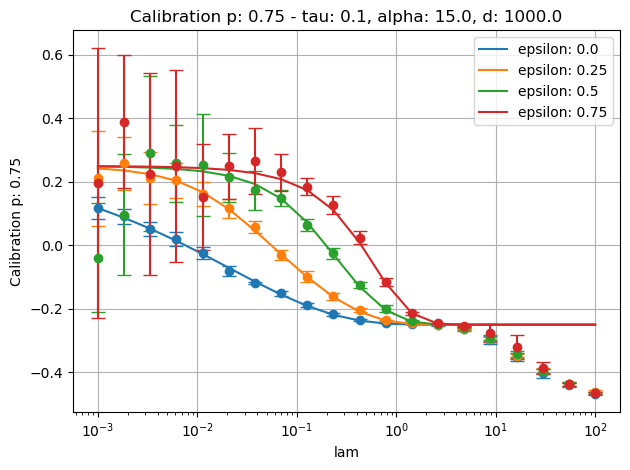

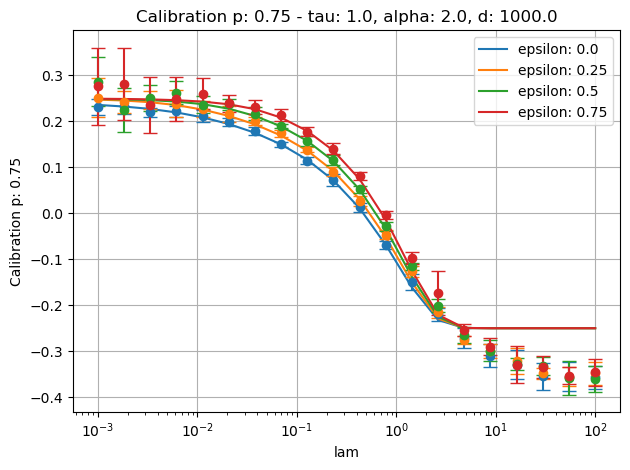

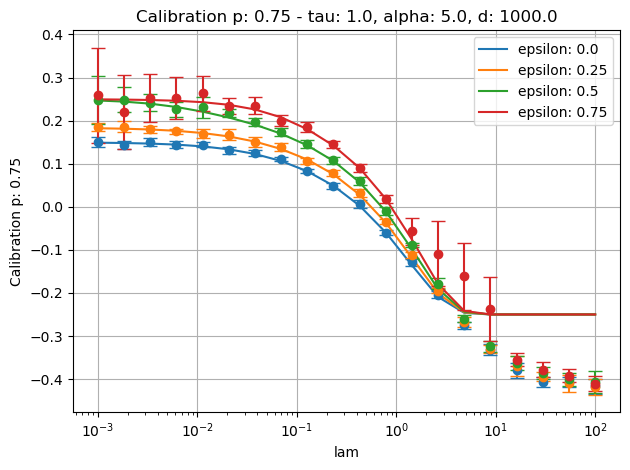

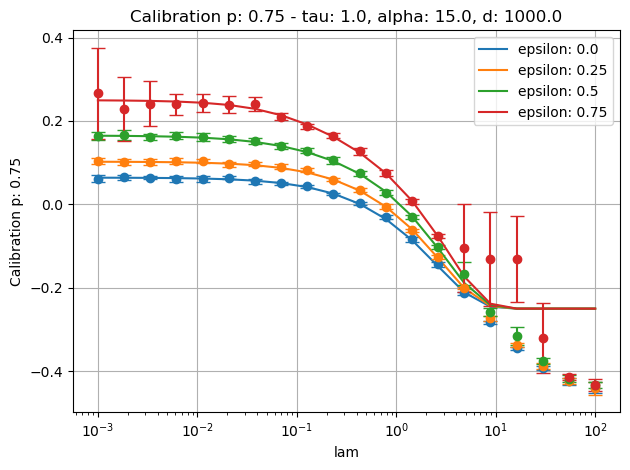

In [75]:
# subset df to keep only where p = 0.5
p = 0.75
dfp = df[df.index.get_level_values("p") == p]
# remove epsilon = 1
dfp = dfp[dfp.index.get_level_values("epsilon") != 1]
create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False,log_x=True)
# erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


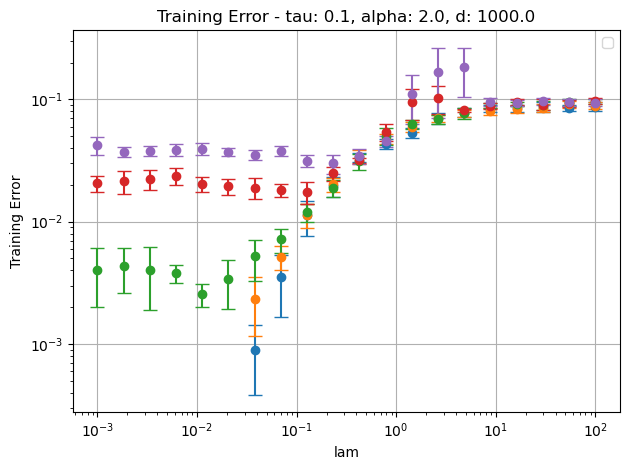

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


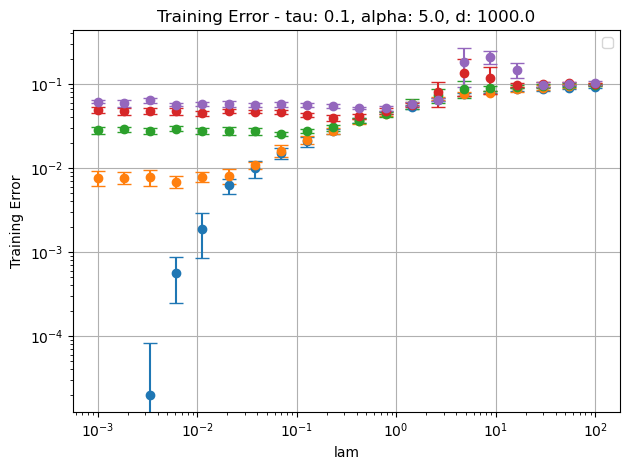

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


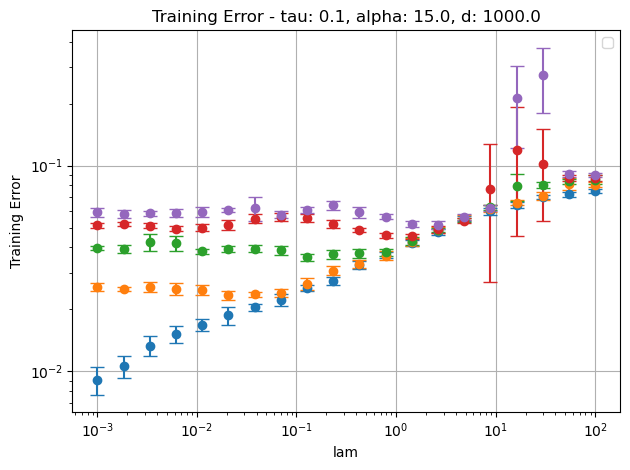

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


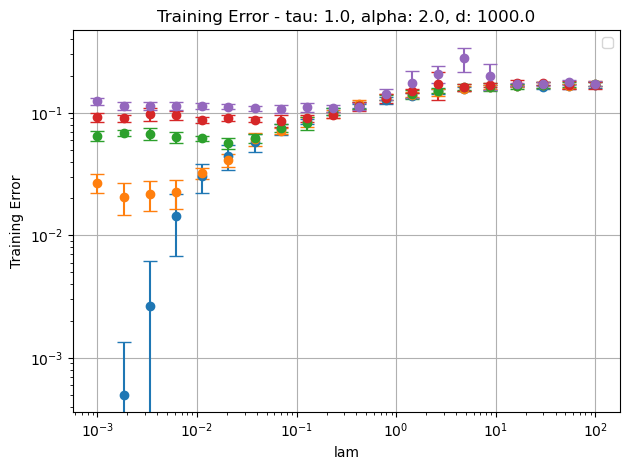

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


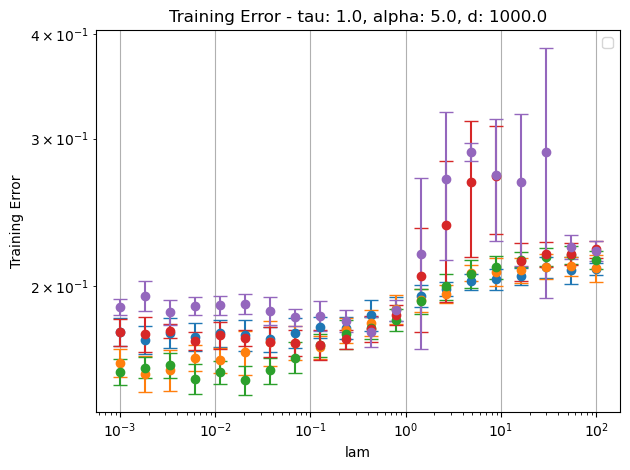

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


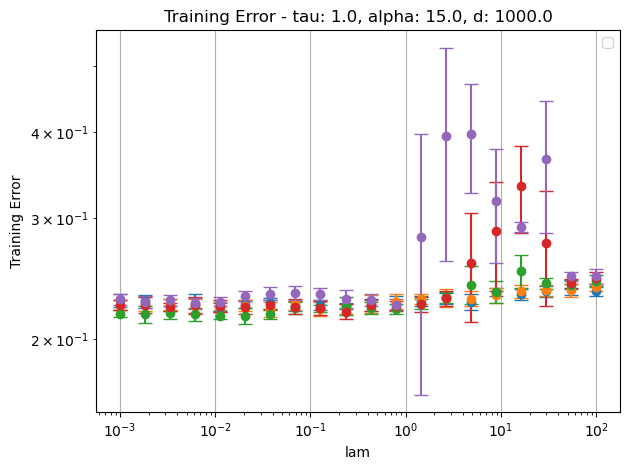

In [64]:
# plot the erm training error
create_plot(df, "Training Error", None,"training_error_erm")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


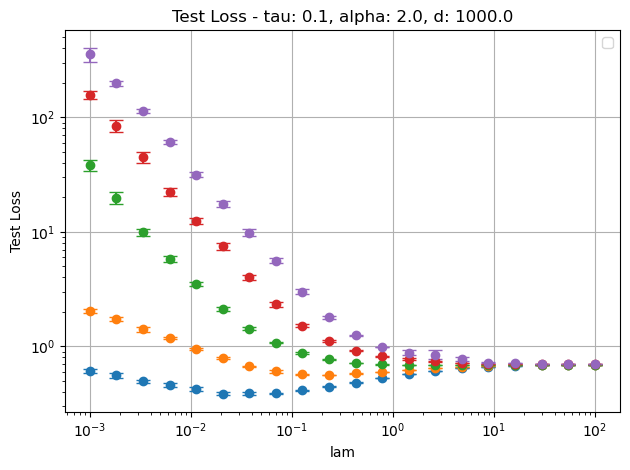

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


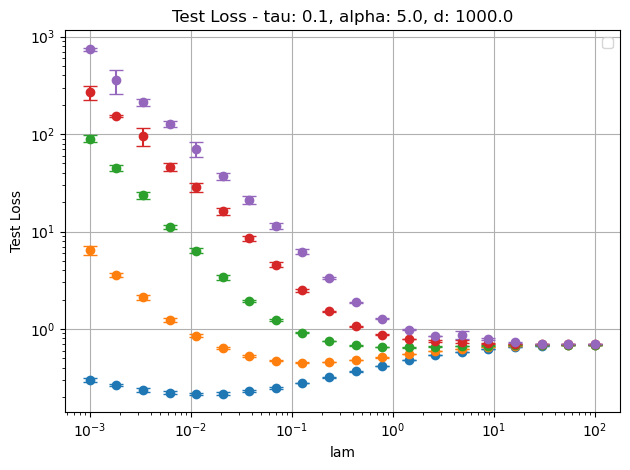

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


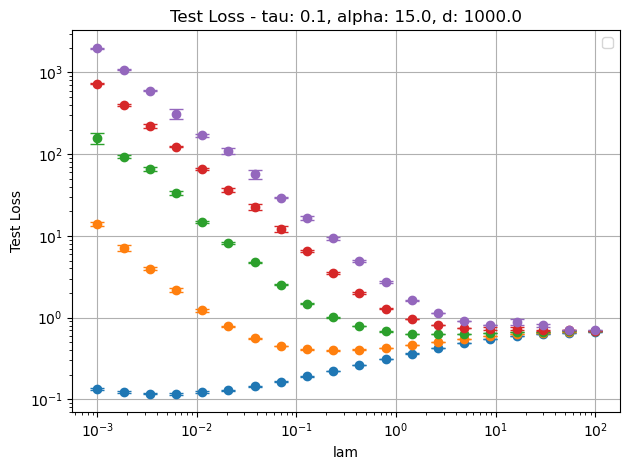

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


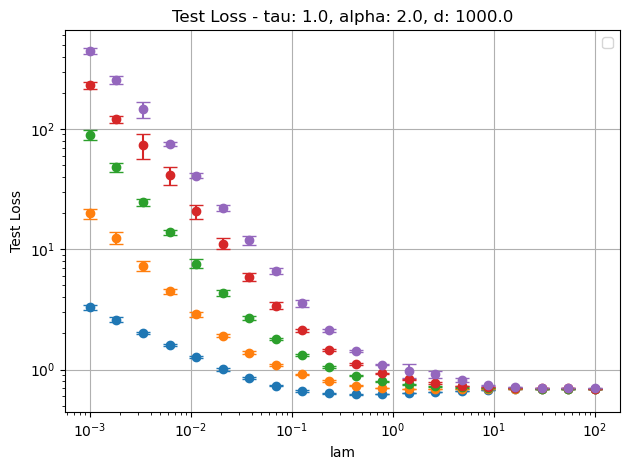

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


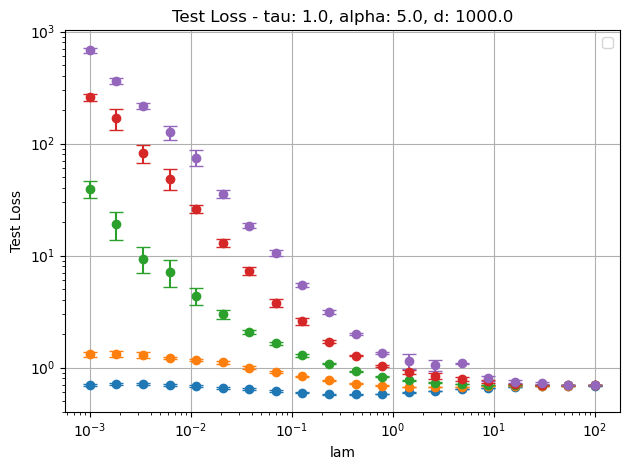

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


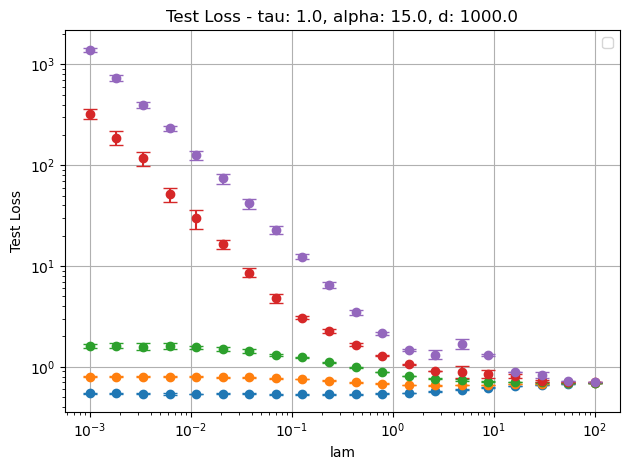

In [65]:
# plot test loss erm
create_plot(df, "Test Loss", None,"test_loss_erm",log_y=True)

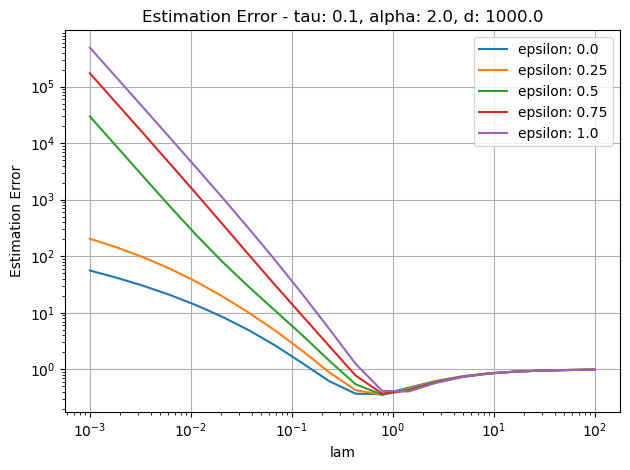

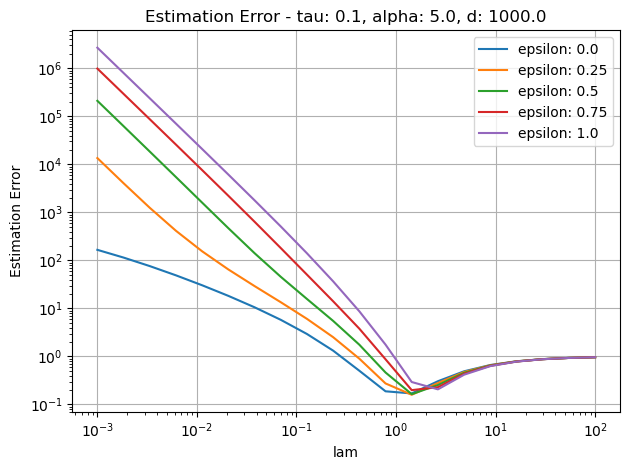

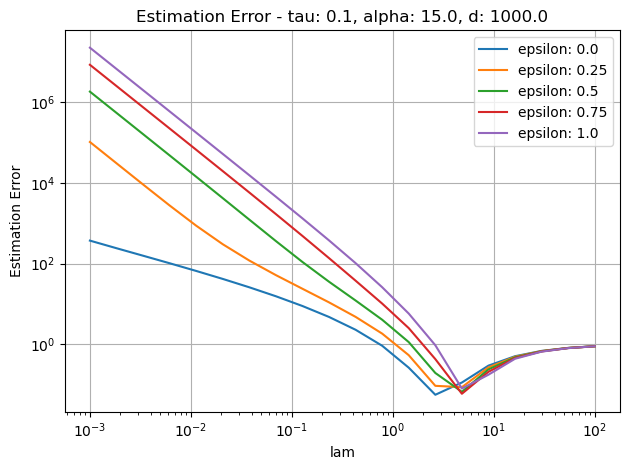

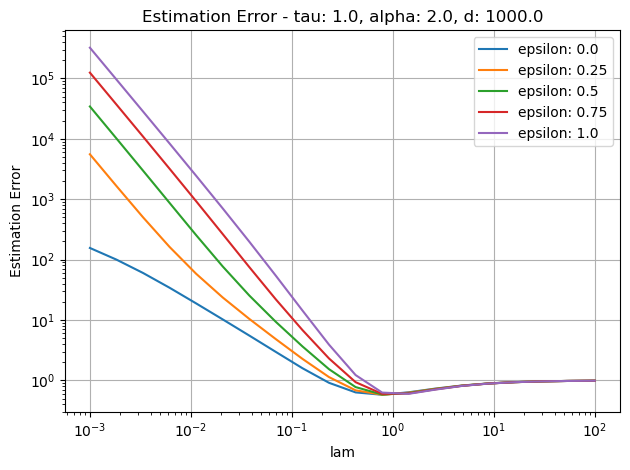

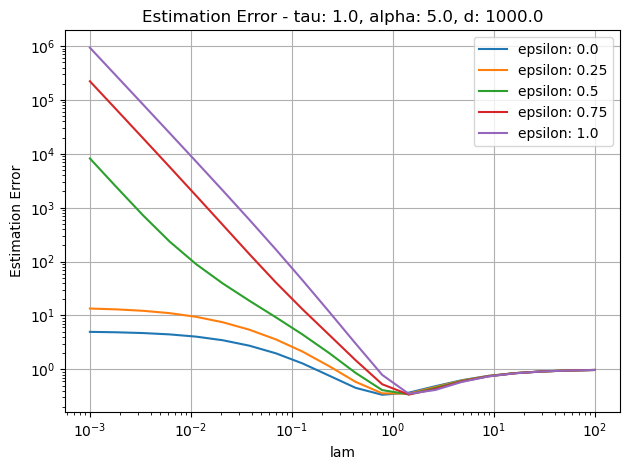

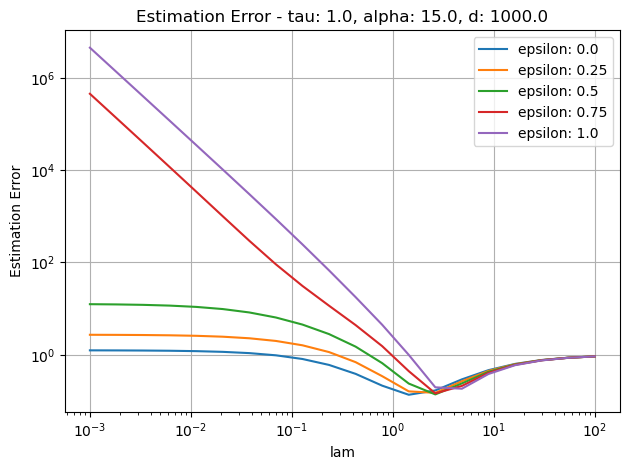

In [66]:
# plot estimation_error_state_evolution
create_plot(df, "Estimation Error", "estimation_error_state_evolution",None,log_y=True)

## Log-Log Plots of overlaps in State_evolution

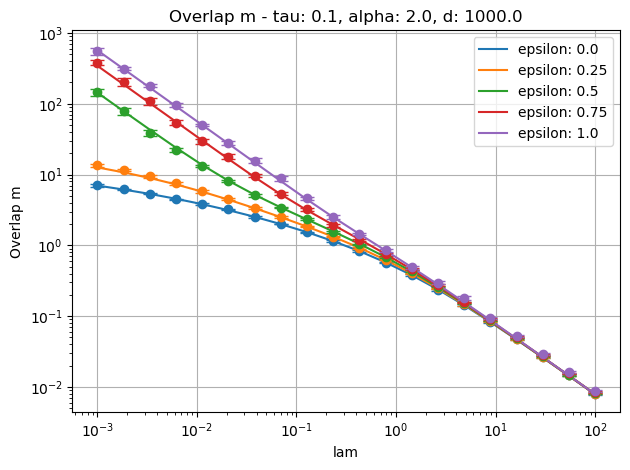

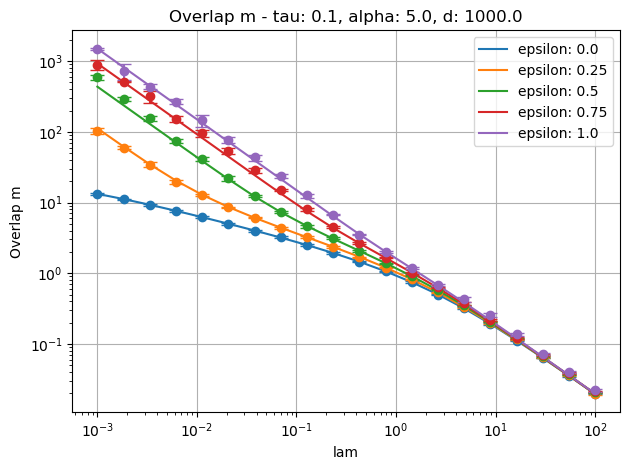

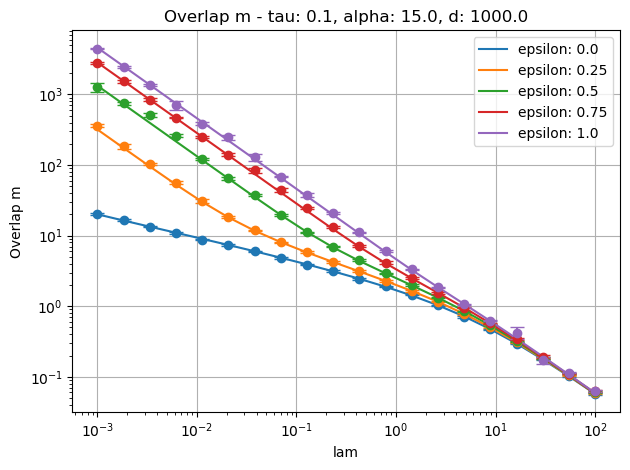

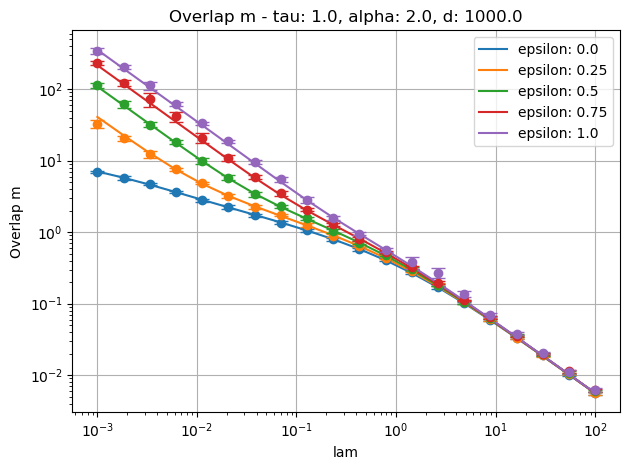

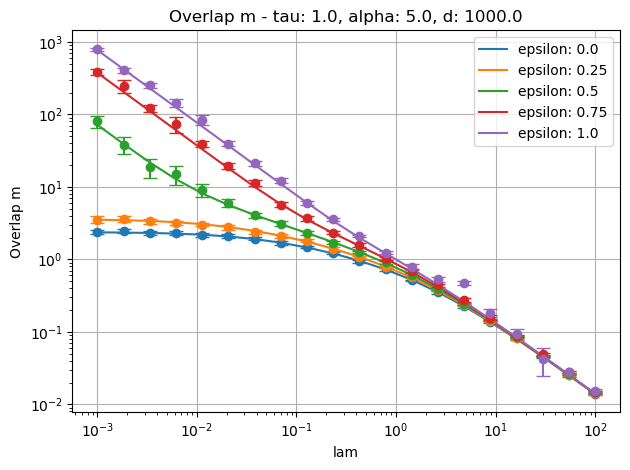

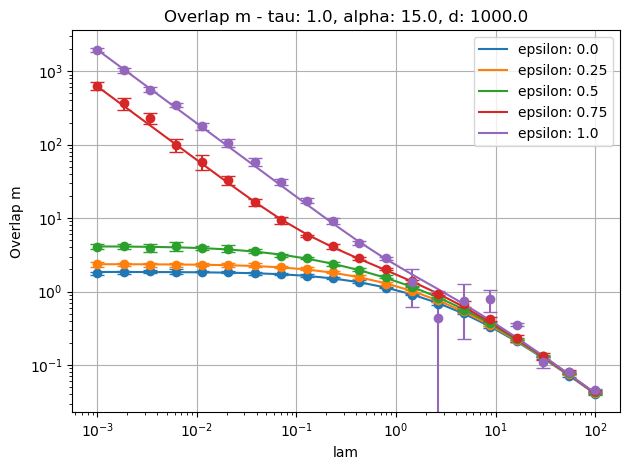

In [67]:
# create a log-log plot of the overlap m
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_x=True, log_y=True)

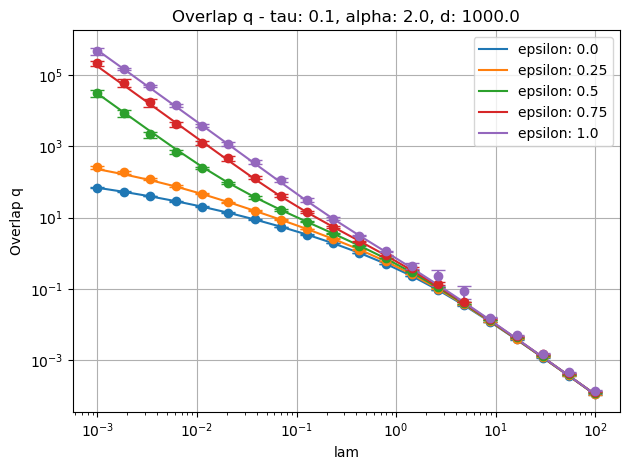

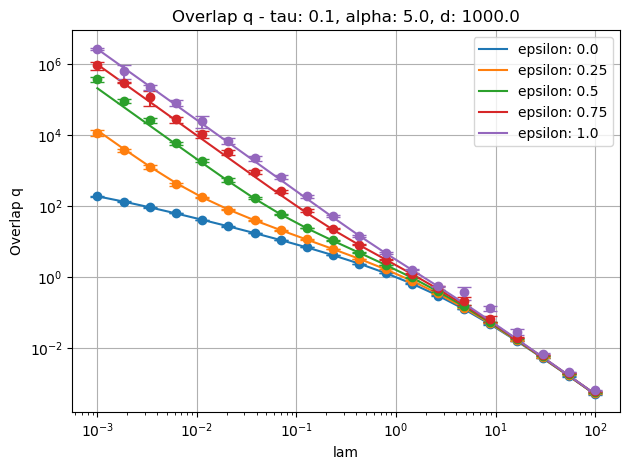

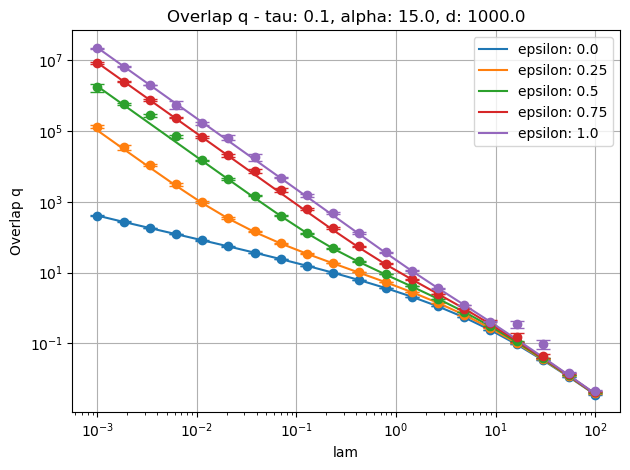

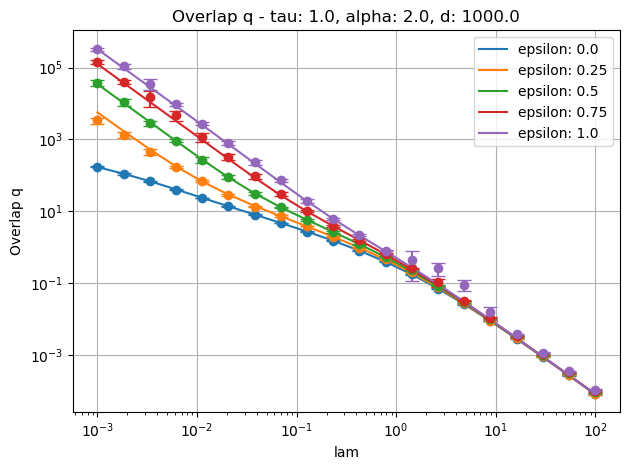

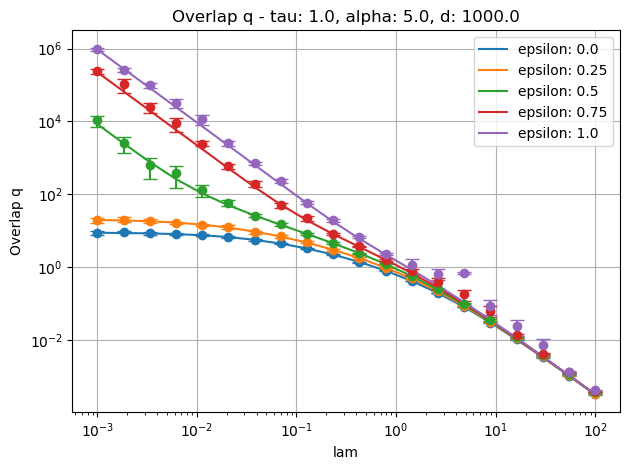

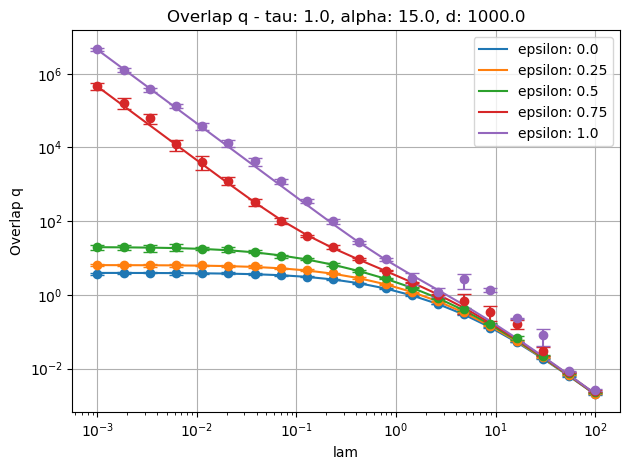

In [68]:
# create a log-log plot of the overlap q
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_x=True, log_y=True)

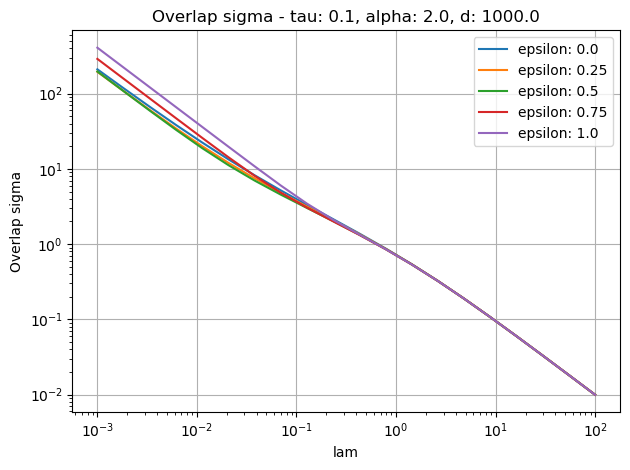

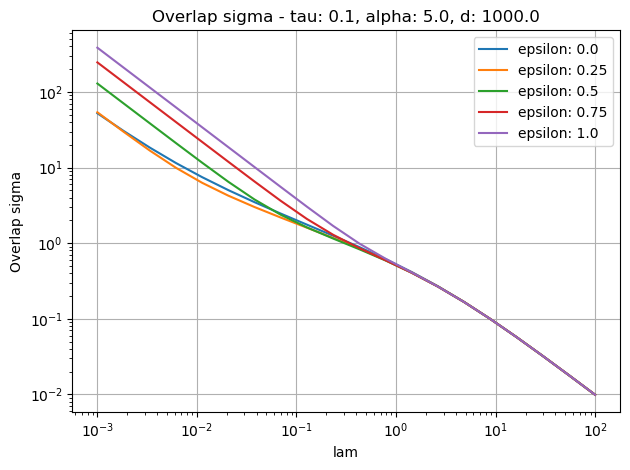

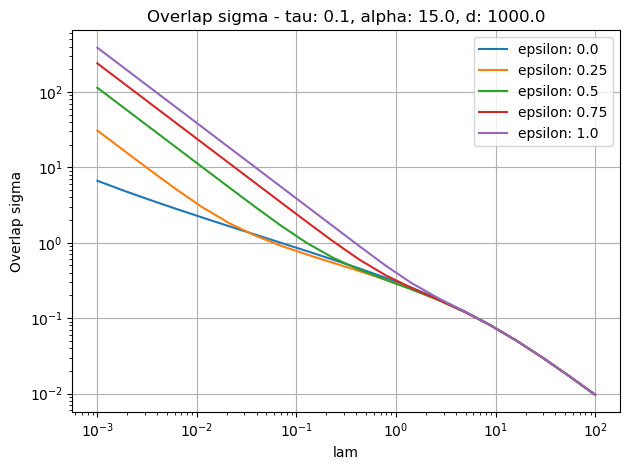

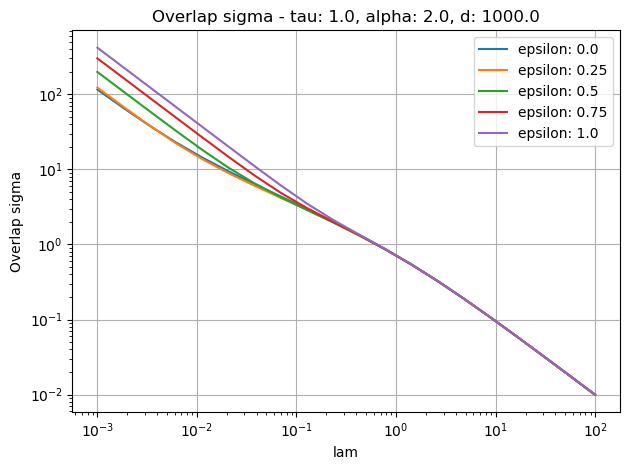

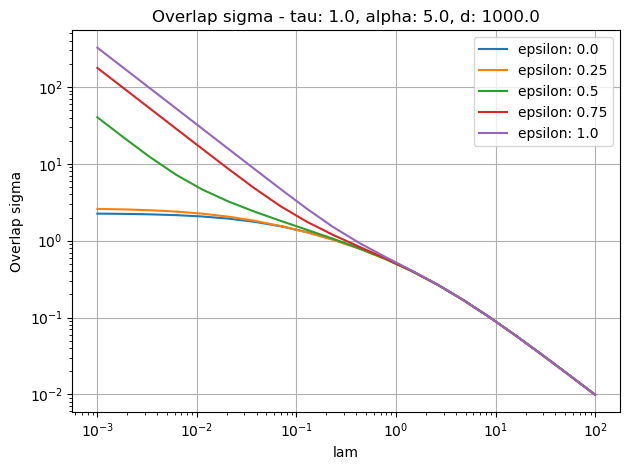

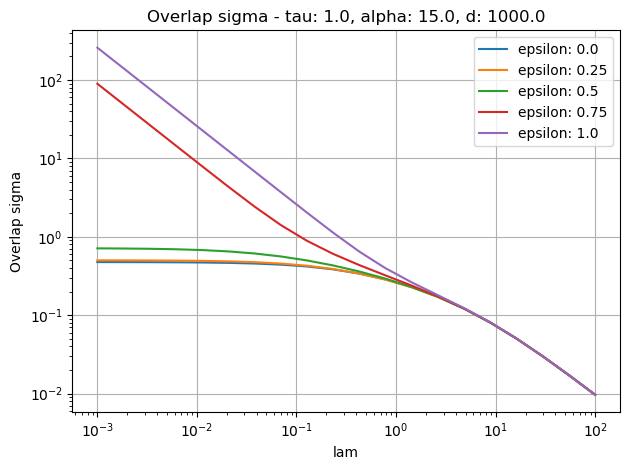

In [69]:
# create a log-log plot of the overlap sigma
create_plot(df, "Overlap sigma", "sigma_state_evolution",None, log_x=True, log_y=True)

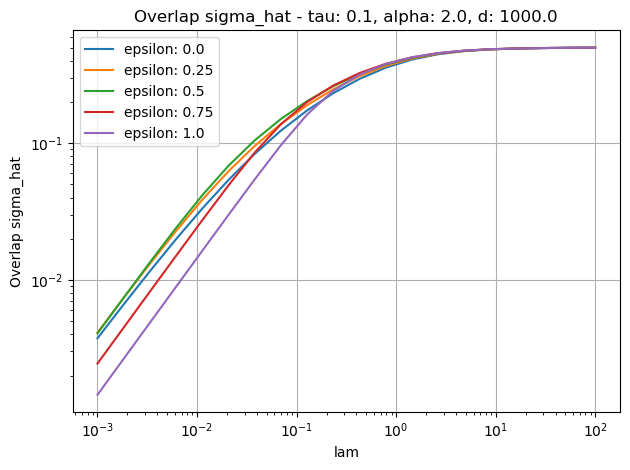

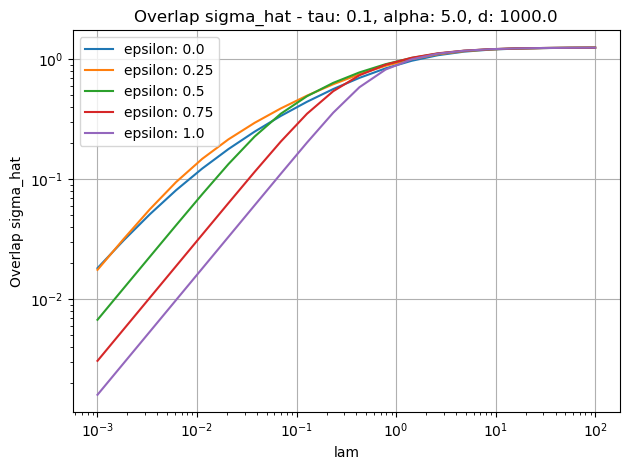

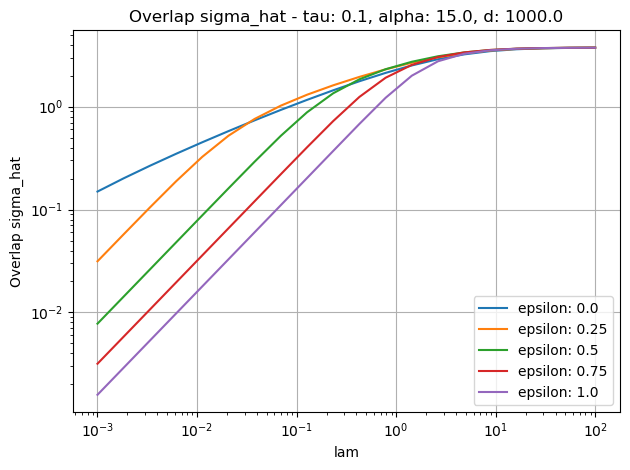

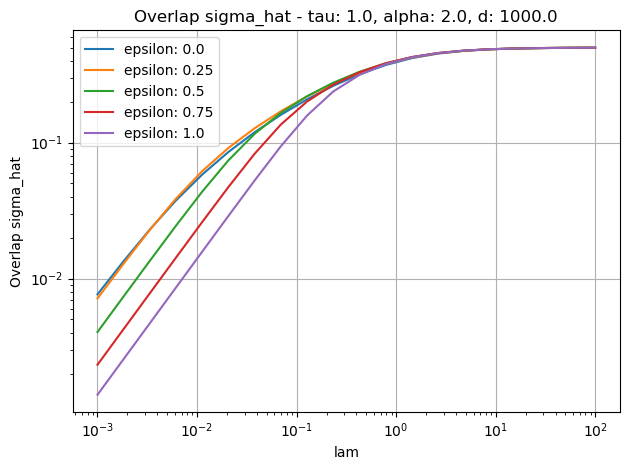

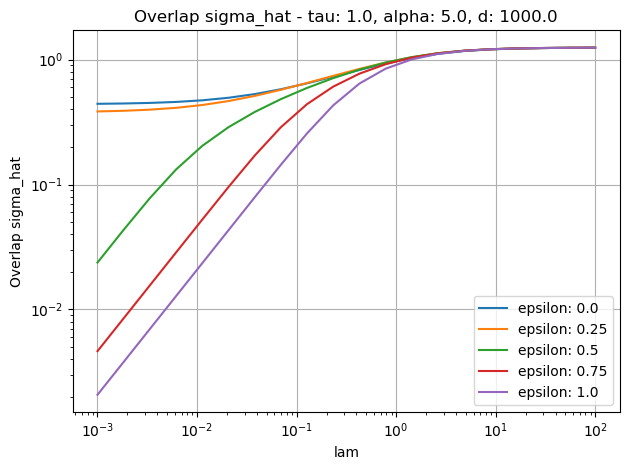

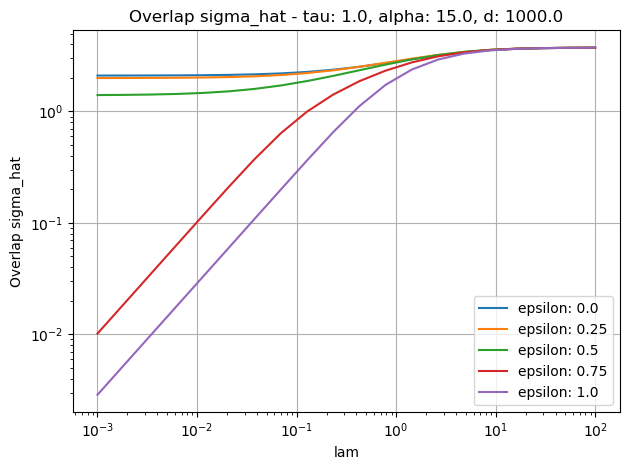

In [70]:
# create a log-log plot of the overlap sigma_hat
create_plot(df, "Overlap sigma_hat", "sigma_hat_state_evolution",None, log_x=True, log_y=True)

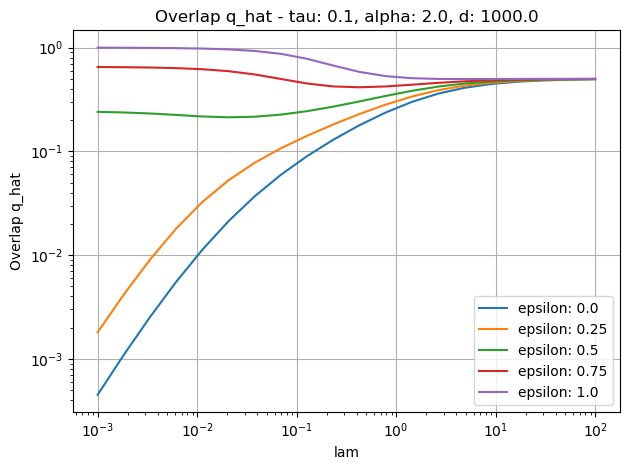

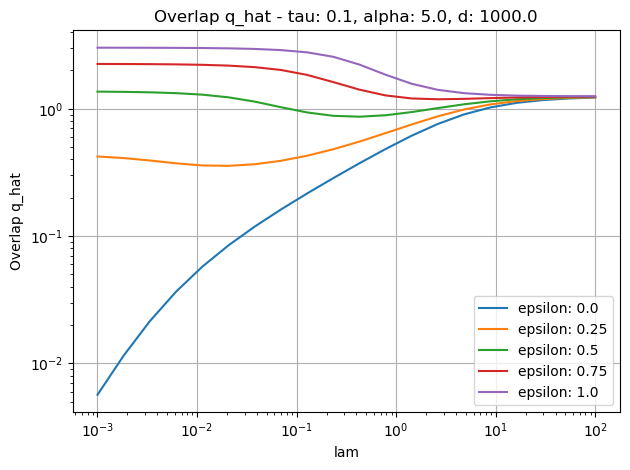

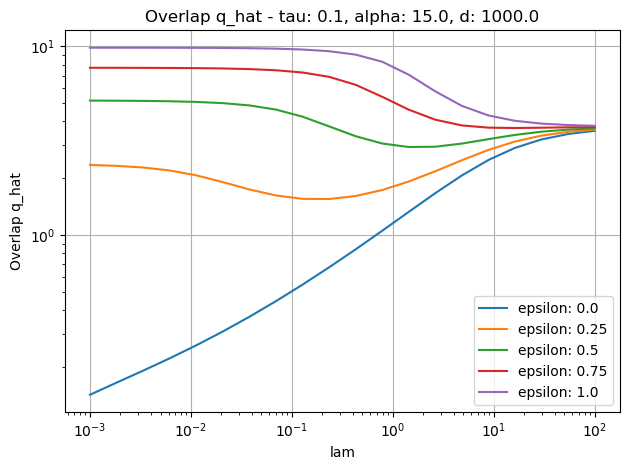

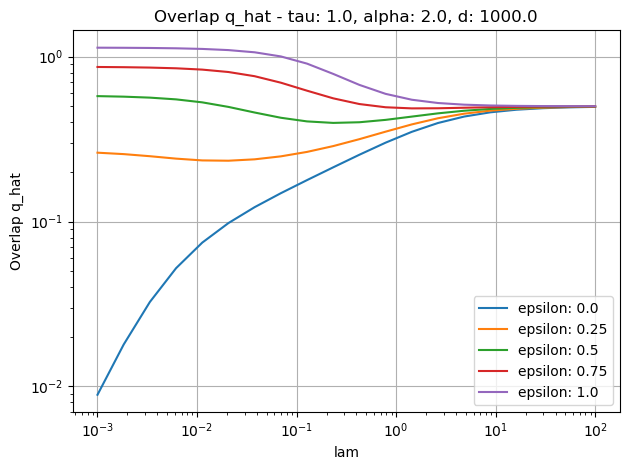

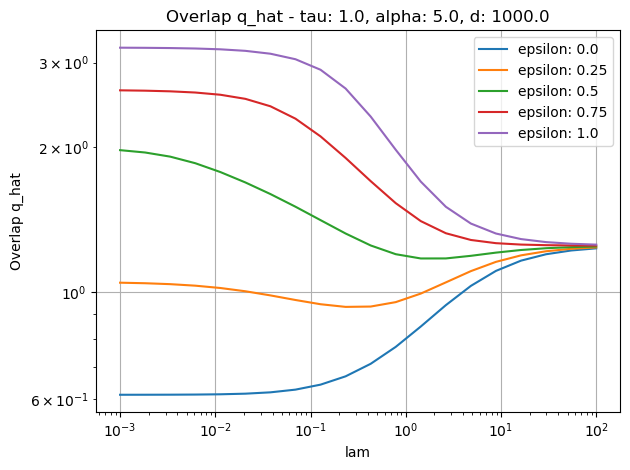

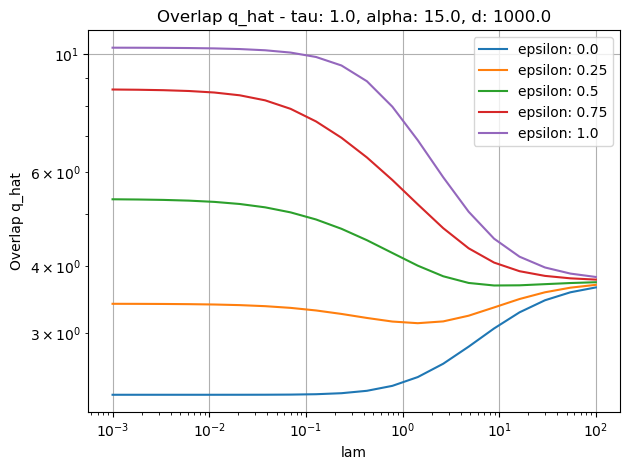

In [71]:
# create a log-log plot of the overlap q_hat
create_plot(df, "Overlap q_hat", "q_hat_state_evolution",None, log_x=True, log_y=True)

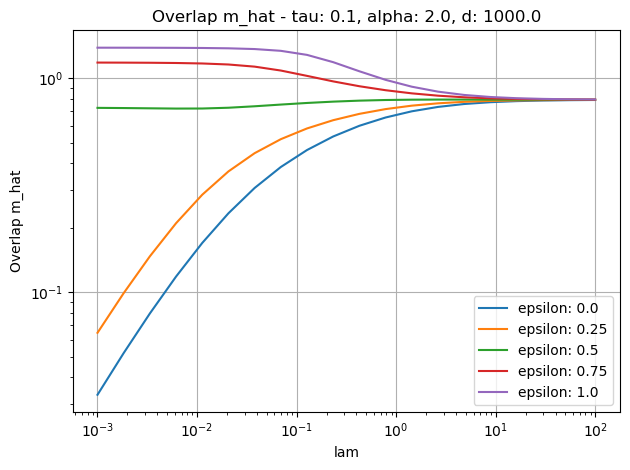

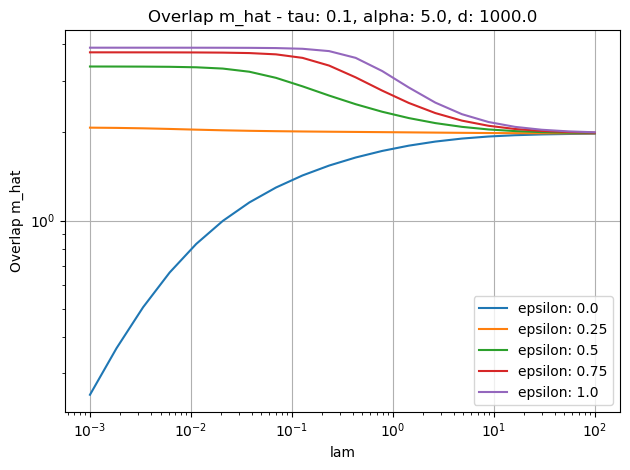

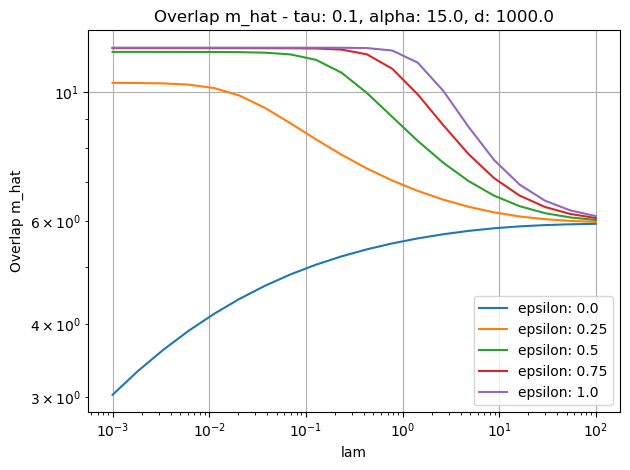

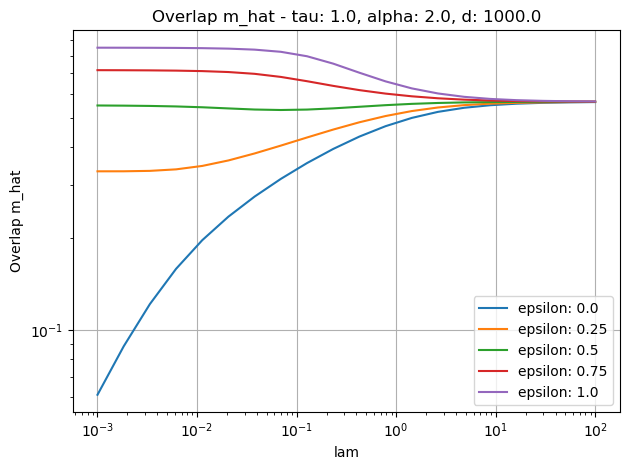

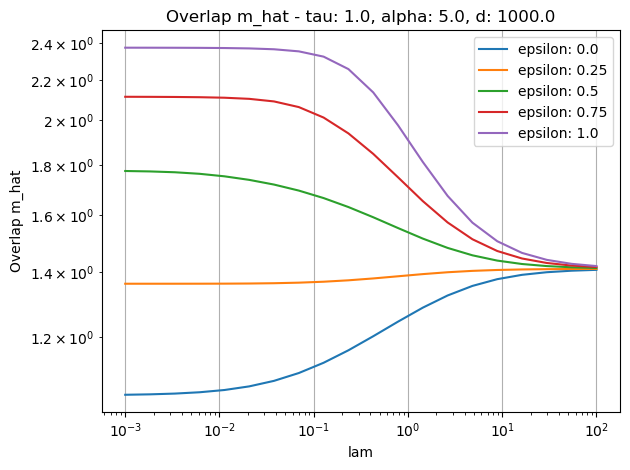

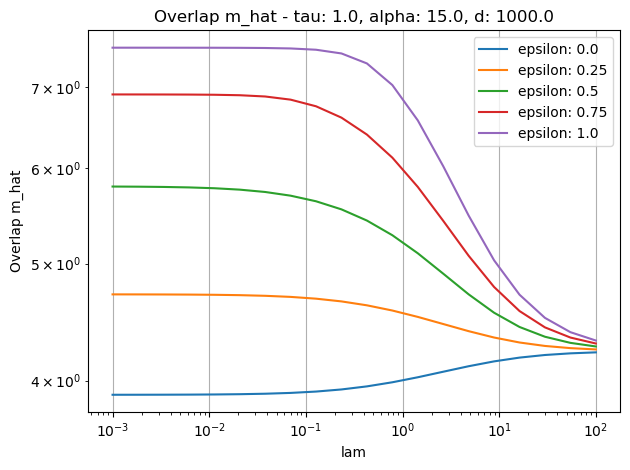

In [72]:
# create a log-log plot of the overlap m_hat
create_plot(df, "Overlap m_hat", "m_hat_state_evolution",None, log_x=True, log_y=True)

In [73]:
# # Create a SweepExperiment
def get_default_experiment():
    state_evolution_repetitions: int = 1
    erm_repetitions: int = 5
    alphas: np.ndarray = np.linspace(0.1,5,8)
    epsilons: np.ndarray = np.linspace(1.0,1.5,4)
    lambdas: np.ndarray = np.array([10])
    taus: np.ndarray = np.array([0.1,1.])
    ps: np.ndarray = np.array([0.75])
    dp: float = 0.01
    d: int = 1000
    erm_methods: list = ["sklearn"]
    experiment_name: str = "Default Experiment"
    experiment = ExperimentInformation(state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,taus,d,erm_methods,ps,dp,experiment_name)
    return experiment
experiment = get_default_experiment()
# # use json dump to save the experiment parameters
with open("experiments/sweep_experiment_test.json","w") as f:
    # use the NumpyEncoder to encode numpy arrays
    json.dump(experiment.__dict__,f,cls=NumpyEncoder)